# Part 1: Data Understanding

## Loading and First Inspection

We start by loading the raw dataset and performing a first structural inspection.  
This step helps us understand the **size**, **number of features**, and **data types** before making any assumptions or transformations.

In [1]:
import pandas as pd

df = pd.read_csv("datasets/Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  object 
 1   dateAdded           10000 non-null  object 
 2   dateUpdated         10000 non-null  object 
 3   address             10000 non-null  object 
 4   categories          10000 non-null  object 
 5   primaryCategories   10000 non-null  object 
 6   city                10000 non-null  object 
 7   country             10000 non-null  object 
 8   keys                10000 non-null  object 
 9   latitude            10000 non-null  float64
 10  longitude           10000 non-null  float64
 11  menuPageURL         1679 non-null   object 
 12  menus.amountMax     10000 non-null  float64
 13  menus.amountMin     10000 non-null  float64
 14  menus.currency      10000 non-null  object 
 15  menus.dateSeen      10000 non-null  object 
 16  menus

From the output of `df.info()`, we observe that the dataset contains **10,000 observations** and **24 features**. Most variables are stored as `object`, even when they represent dates or structured information, suggesting that several columns may benefit from type conversion in later steps.  

Additionally, some features present **missing values** (e.g. menu URLs, descriptions, postal codes), while others are complete. At this stage, we do not apply any cleaning: the goal is simply to assess the raw structure of the data and identify aspects that require deeper investigation in the following sections.

### ID and Name

In [2]:
counts = df['id'].value_counts()
dupes = counts[counts > 1]
rowsWithDups = df[df['id'].duplicated(keep=False)].sort_values('id')
print(f"Number of duplicated IDs: {len(dupes)}")

Number of duplicated IDs: 1518


We can see that ID is not unique, but it represents the ID of the business. So an ID should be connected with the name of the business.

We will test in two different cases:
1. Each id has only one name?
2. Each name has only one id?

In [3]:
# First theory: each id has only one name

byID = df.groupby('id')['name'].nunique() # number of unique names per id

print("Distinct ids:", byID.size)
print("Ids with exactly 1 name:", int((byID == 1).sum()), f"({(byID == 1).mean():.2%})")
print("Ids with >1 name (anomalies):", int((byID > 1).sum()))

# printing somes anomalies
if (byID > 1).any():
    sample_ids = byID[byID > 1].index[:5]
    print("\nSample (id ↔ names):")
    print(
        df.loc[df['id'].isin(sample_ids), ['id','name']]
          .drop_duplicates()
          .sort_values(['id','name'])
          .head(20)
          .to_string(index=False)
    )

Distinct ids: 2285
Ids with exactly 1 name: 2285 (100.00%)
Ids with >1 name (anomalies): 0


In [4]:
# Second theory: each name has only one 

# Test B — name → id
byName = df.groupby('name')['id'].nunique() # number of unique ids per name

print("Distinct names:", byName.size)
print("Names with exactly 1 id:", int((byName == 1).sum()), f"({(byName == 1).mean():.2%})")
print("Names with >1 id (chains/homonyms):", int((byName > 1).sum()))

# printing somes anomalies
if (byName > 1).any():
    sample_names = byName[byName > 1].sort_values(ascending=False).index[:5]
    print("\nSample (name <-> ids):")
    print(
        df.loc[df['name'].isin(sample_names), ['name','id','city','province']]
          .drop_duplicates()
          .sort_values(['name','city','province','id'])
          .head(5)
          .to_string(index=False)
    )

Distinct names: 1827
Names with exactly 1 id: 1656 (90.64%)
Names with >1 id (chains/homonyms): 171

Sample (name <-> ids):
                 name                   id           city province
Little Caesar's Pizza AWEKUydU3-Khe5l_edBW         Dayton       OH
Little Caesar's Pizza AWEKTwbZa4HuVbedMB00       Española       NM
Little Caesar's Pizza AVwdCs4skufWRAb51sjs       Hartford       WI
Little Caesar's Pizza AVwdDoS8_7pvs4fz1zoW Hendersonville       NC
Little Caesar's Pizza AVweURCU_7pvs4fzB7G2   Indianapolis       IN


From the code above we can answer the two questions:
1. Yes. Each ID maps to exactly one name (for that business).
2. No. 171 names map to more than one ID, so name is not unique and cannot be used as a key.

### Date columns

The columns in question are dateAdded, dateUpdated and menu.dateSeen. For menu.dateSeen we can just convert it but for dateAdded and dateUpdated there's something more.

The hypothesis is, for this features, that:
- dateAdded is the first observation for the business
- dateUpdated is the last 

In [5]:
da = pd.to_datetime(df['dateAdded'])
du = pd.to_datetime(df['dateUpdated'])

# invarianti base
okAdded  = (da.groupby(df['id']).transform('min') == da).all()
okUpdated = (du.groupby(df['id']).transform('max') == du).all()
okOrder  = (du >= da).all()

print("dateAdded is first per id:", okAdded)
print("dateUpdated is last per id:", okUpdated)
print("dateUpdated >= dateAdded:", okOrder)

dateAdded is first per id: True
dateUpdated is last per id: True
dateUpdated >= dateAdded: True


This observation confirms our initial hypothesis: several columns stored as `object` types actually encode temporal information. From these fields, it would be possible to engineer additional features such as:

- the **age of the business** (derived from the creation date),
- the **time since the last update** of the record.

Such features could provide valuable signals in downstream analyses or modeling tasks.  
However, at this stage we deliberately postpone feature engineering. Instead, we focus on converting variables to more appropriate data types (e.g. parsing dates), in order to work with a cleaner and more semantically correct representation of the data in the next steps.

In [6]:
dateCols = ['dateAdded', 'dateUpdated', 'menus.dateSeen']
for c in dateCols:
    df[c] = pd.to_datetime(
        df[c], 
        errors='coerce', # coercing errors to NaT
        utc=True,  # assuming UTC timezone
        format="mixed" # letting pandas infer format
        ) 

df[dateCols].dtypes

dateAdded         datetime64[ns, UTC]
dateUpdated       datetime64[ns, UTC]
menus.dateSeen    datetime64[ns, UTC]
dtype: object

### String columns

Several variables in the dataset represent **pure textual or categorical information**, such as identifiers, location fields, and descriptive attributes (e.g. IDs, addresses, categories, city and province names, menu descriptions, and currency codes).

For these columns, the most appropriate choice is to explicitly cast them to a **string type** and apply basic normalization (e.g. consistent casing, trimming whitespace). This ensures a uniform representation across the dataset, reduces the risk of hidden inconsistencies, and prepares the data for reliable grouping, filtering, and analysis in later stages.

In [7]:
from src.utilities import clean_strings

stringCols = [
    'id', 'address', 'categories',
    'primaryCategories', 'city', 'country',
    'keys', 'menuPageURL', 'menus.currency',
    'menus.description', 'menus.name','name',
    'priceRangeCurrency','province'
    ]

df[stringCols] = df[stringCols].astype('string') # convert to string dtype

for c in stringCols:
    df[c] = clean_strings(df[c])

df['city'] = df['city'].str.title()
for c in ['country','province','menus.currency','priceRangeCurrency']:
    df[c] = df[c].str.upper()

### Numeric Columns
It is appropriate to assign numeric value to some columns: only postalCode in this case.

In [8]:
df['postalCode'] = pd.to_numeric(
    df['postalCode'],
    errors='coerce', # coercing errors to NaN
    downcast='integer' # downcasting to smallest integer subtype
    )

## Data Dictionary

* **id** - Business ID (unique per business; repeats across rows because each row is a menu item).
* **dateAdded** - First time the business record appears (UTC).
* **dateUpdated** - Last time the business record was seen/updated (UTC, ≥ `dateAdded`).
* **address** - Street address.
* **categories** - Raw categories collected from sources.
* **primaryCategories** - Normalized/primary categories.
* **city** - City.
* **country** - Country code (e.g., US).
* **keys** - Source merge keys for reconciliation (serialized list).
* **latitude** - Latitude.
* **longitude** - Longitude.
* **menuPageURL** - URL of the menu page.
* **menus.amountMax** - Max price for the menu item/size.
* **menus.amountMin** - Listed/min price for the menu item.
* **menus.currency** - Currency for menu prices.
* **menus.dateSeen** - When that item/price was observed (UTC).
* **menus.description** - Menu item description.
* **menus.name** - Menu item name.
* **name** - Business name (not unique; a name can map to multiple IDs).
* **postalCode** - ZIP postal code.
* **priceRangeCurrency** - Currency of the business-level price band.
* **priceRangeMin** - Lower bound of the business price band.
* **priceRangeMax** - Upper bound of the business price band.
* **province** - State/province code (e.g., CA, NY).

For easier ffurther analisys the dataframe can be divided in two sub-tables:
1. Business: the table for unique ids
2. Menu items: it's useless to create another tabel just for that, we already have the full dataset.

In [9]:
dfUniqueID = df.drop_duplicates(subset=['id']).reset_index(drop=True)
dfUniqueID.head()

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,...,menus.currency,menus.dateSeen,menus.description,menus.name,name,postalCode,priceRangeCurrency,priceRangeMin,priceRangeMax,province
0,AVz3Y-7h3D1zeR_xDAqm,2017-06-30 05:05:40+00:00,2019-05-01 15:43:09+00:00,4203 E Kiehl Ave,"Pizza,Restaurant,American restaurants,Pizza Pl...",Accommodation & Food Services,Sherwood,US,us/ar/sherwood/4203ekiehlave/-1051391616,34.832300,...,USD,NaT,<NA>,Cheese Pizza,Shotgun Dans Pizza,72120.0,USD,0,25,AR
1,AVweGPFF_7pvs4fzAAzQ,2016-04-02 04:02:49+00:00,2019-05-01 15:27:50+00:00,25 E Camelback Rd,"Pizza,Pizza Place,Restaurants",Accommodation & Food Services,Phoenix,US,us/az/phoenix/25ecamelbackrd/-727422936,33.509266,...,USD,NaT,<NA>,Pizza Cookie,Sauce Pizza Wine,85012.0,USD,0,25,AZ
2,AVwdRGa9_7pvs4fz4E3K,2016-03-03 18:39:49+00:00,2019-05-01 12:52:25+00:00,3703 Paxton Ave,"Restaurant,Pizza Place,Restaurants",Accommodation & Food Services,Cincinnati,US,us/oh/cincinnati/3703paxtonave/-619797122,39.144883,...,USD,NaT,a saucelessampcomma double cheese pizza with a...,Pizza Blanca,Mios Pizzeria,45209.0,USD,0,25,OH
3,AVwdX4psIN2L1WUfvJB1,2016-03-29 05:08:59+00:00,2019-05-01 12:52:20+00:00,30495 John R Rd,"Pizza,Carry-out food,Pizza Place,Restaurants",Accommodation & Food Services,Madison Heights,US,us/mi/madisonheights/30495johnrrd/-874863116,42.516669,...,USD,NaT,<NA>,Small Pizza,Hungry Howies Pizza,48071.0,USD,25,40,MI
4,AVwdaeTtkufWRAb55pSH,2016-03-31 02:34:04+00:00,2019-05-01 12:50:45+00:00,3600 Eastern Ave,"Pizza,American restaurants,Pizza Place,Pizza e...",Accommodation & Food Services,Baltimore,US,us/md/baltimore/3600easternave/-1270965359,39.286630,...,USD,2016-03-31 02:34:04+00:00,<NA>,Pizza Sub,Spartan Pizzeria,21224.0,USD,0,25,MD


## Data Analisys questions

1. What are the most bought pizas accross the USA? 
2. Costal cities have higher prices than internal cities?
3. Is there a statistically significant difference in the average menu price across the main pizza categories?
4. Do the business-level price ranges (priceRangeMin/Max) align with actual menu item prices? How consistent is that alignment by state?

# Part 2: Data Cleaning & Preparation

## Handling missing values
From dataset infos, after we have converted all of them either specific values or NaN (NaT for dates), it's possible to see that features with missing values are:
1. menuPageURL
2. menus.dateSeen
3. menus.description
4. postalCode

In [10]:
missing = df.isna().mean().sort_values(ascending=False)*100

for col, pct in missing[missing > 0].items():
    print(f"{col:25s}: {pct:5.2f}% missing")

menuPageURL              : 83.21% missing
menus.dateSeen           : 79.72% missing
menus.description        : 62.82% missing
postalCode               :  0.27% missing


menuPageURL, menus.dateSeen and menus.description are (basically) useless, we can drop it. PostalCode does not have so much missing values, we can keep it and pay attention later.

In [11]:
df.drop(columns=
    ["menuPageURL", 
    "menus.dateSeen", 
    "menus.description"], 
    axis=1, 
    inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   id                  10000 non-null  string             
 1   dateAdded           10000 non-null  datetime64[ns, UTC]
 2   dateUpdated         10000 non-null  datetime64[ns, UTC]
 3   address             10000 non-null  string             
 4   categories          10000 non-null  string             
 5   primaryCategories   10000 non-null  string             
 6   city                10000 non-null  string             
 7   country             10000 non-null  string             
 8   keys                10000 non-null  string             
 9   latitude            10000 non-null  float64            
 10  longitude           10000 non-null  float64            
 11  menus.amountMax     10000 non-null  float64            
 12  menus.amountMin     10000 non-nul

## Handling duplicates

In [12]:
from src.utilities import check_row_duplicates

originalShape = df.shape

for row in check_row_duplicates(df).itertuples():
    df.drop(index=row.Index, inplace=True)
    
print(f"Removed {originalShape[0] - df.shape[0]} duplicate rows.")

Removed 632 duplicate rows.


## Correction of Inconsistencies and formatting
Correction of Dtypes has already been done on part 1. Checking on values is needed only on columns: country, menus.currency, priceRangeCurrency.

In [13]:
print('Country in dataset are only "US": ', (df['country'] == 'US').all())
print('Menu currency is always "USD": ', (df['menus.currency'] == 'USD').all())
print('Price range currency is always "USD": ', (df['priceRangeCurrency'] == 'USD').all())

Country in dataset are only "US":  True
Menu currency is always "USD":  True
Price range currency is always "USD":  True


### menus.name

In [14]:
df['menus.name'].nunique()

4653

Clearly, `menus.name` is a noisy field: item names are inconsistently formatted, often include marketing text, and mix together multiple pieces of information (size, crust, dietary claims, product type, etc.).  
To make this column usable and interpretable, we apply a **two-step approach**: normalization + semantic enrichment, using code in `src/cleaner.py`.

First, we standardize each item name with a lightweight normalization routine (`_basic_normalize`): lowercasing, removing HTML entities and non-alphanumeric characters, and harmonizing separators. We also remove common “noise” expressions (e.g., *signature*, *special*, and even the word *pizza* when appropriate) to reduce redundant vocabulary.

Next, we enrich the text by extracting explicit, human-readable attributes with regex patterns (`_extract_attributes`). In particular, we detect:
- **Size** (e.g., small/medium/large/xlarge),
- **Dietary labels** (e.g., gluten-free, vegan, vegetarian, keto),
- **Product form** (e.g., slice, calzone, stromboli, garlic bread, pasta),
- **Crust style** (e.g., thin, deep-dish, pan, stuffed),
- A coarse **topping count** when stated (1, 2, 3+ toppings),
- Additional **style tags** (e.g., margherita, bbq, buffalo).

These signals are encoded as **binary features** (dummy columns) and also injected into an **enriched text representation** through structured tokens (e.g., `size=large`, `crust=thin`, `diet=vegan`). This hybrid representation preserves interpretability while making the text easier to cluster.

The enriched strings are then vectorized with **TF-IDF** (including n-grams) to obtain a scalable sparse representation. Clustering is performed with **BIRCH**, which efficiently groups similar menu items without requiring expensive pairwise distance computations and works well on large sparse feature spaces.

Finally, each cluster is summarized in a compact and interpretable way: we assign a representative label (the most frequent original value in the cluster) and produce a cluster report with:
- cluster size (weighted by frequency in the dataset),
- top examples,
- top TF-IDF keywords,
- and (if enabled) attribute prevalence within the cluster.

This produces cleaner, more consistent menu item labels and structured features that can be used downstream for analysis and modeling.

In [15]:
import src.cleaner as cleaner
df, cluster_summary = cleaner.clean_categorical_column(
    df=df,
    column="menus.name",
    new_column="menus.cleanedNames",
    cluster_id_column="menus.cluster_id",
    birch_threshold=0.6,
    dummy_prefix ="menu_"
)

# --- AFTER CLUSTERING: group rare cleaned names into "OTHER" ---
print("Unique cleaned names (before):", df["menus.cleanedNames"].nunique(dropna=True))

MIN_COUNT = 30  # adjust: 10 / 20 / 30 / 50 depending on desired compression

vc = df["menus.cleanedNames"].value_counts(dropna=True)
keep = vc[vc >= MIN_COUNT].index

df["menus.cleanedNames"] = df["menus.cleanedNames"].where(
    df["menus.cleanedNames"].isin(keep),
    "OTHER"
)

print("Unique cleaned names (reduced):", df["menus.cleanedNames"].nunique(dropna=True))
print("Share OTHER:", (df["menus.cleanedNames"] == "OTHER").mean().round(3))

Unique cleaned names (before): 1890
Unique cleaned names (reduced): 43
Share OTHER: 0.611


In [16]:
RAW_COL = "menus.name"
CLEAN_COL = "menus.cleanedNames"
CLUSTER_COL = "menus.cluster_id"

TOP_K = 15

n_rows = len(df)
n_raw = df[RAW_COL].nunique(dropna=True)
n_clean = df[CLEAN_COL].nunique(dropna=True)
n_clusters = df[CLUSTER_COL].nunique(dropna=True)

metrics = pd.DataFrame({
    "metric": [
        "Dataset rows",
        "Unique raw menu names (before)",
        "Unique cleaned names (after)",
        "Number of clusters",
        "Cardinality reduction",
    ],
    "value": [
        n_rows,
        n_raw,
        n_clean,
        n_clusters,
        f"{(1 - (n_clean / n_raw)) * 100:.1f}%" if n_raw else "n/a",
    ]
})

# ============================================================
# BEFORE: raw menu names (high cardinality)
# ============================================================

before = (
    df[RAW_COL]
    .fillna("")
    .value_counts()
    .head(TOP_K)
    .rename_axis("menus.name (raw)")
    .reset_index(name="count")
)

before["share_%"] = (before["count"] / n_rows * 100).round(2)

# ============================================================
# AFTER: cluster summary (from cleaner)
# ============================================================

after = (
    cluster_summary
    .sort_values("n_rows", ascending=False)
    .head(TOP_K)
)

# ============================================================
# DISPLAY
# ============================================================

print("\n=== SUMMARY METRICS ===")
display(metrics)

print("\n=== BEFORE: Raw menu names (top frequency) ===")
display(before)

print("\n=== AFTER: Clustered menu items (top clusters) ===")
display(after)



=== SUMMARY METRICS ===


,metric,value
0,Dataset rows,9368
1,Unique raw menu names (before),4653
2,Unique cleaned names (after),43
3,Number of clusters,1890
4,Cardinality reduction,99.1%



=== BEFORE: Raw menu names (top frequency) ===


,menus.name (raw),count,share_%
0,Cheese Pizza,279,2.98
1,White Pizza,197,2.1
2,Hawaiian Pizza,135,1.44
3,Buffalo Chicken Pizza,104,1.11
4,Pizza,99,1.06
5,Margherita Pizza,96,1.02
6,Veggie Pizza,81,0.86
7,Bbq Chicken Pizza,70,0.75
8,Pizza Burger,66,0.7
9,Greek Pizza,64,0.68



=== AFTER: Clustered menu items (top clusters) ===


,cluster_id,n_rows,cluster_rep,top_examples,top_keywords,p_crust_cauliflower,p_crust_chicago,p_crust_deepdish,p_crust_glutenfree,p_crust_handtossed,...,p_size_family,p_size_kids,p_size_large,p_size_medium,p_size_personal,p_size_small,p_size_xlarge,p_topping_1,p_topping_2,p_topping_3plus
0,973,677,Pizza,"[Pizza, 1 Topping Pizza, Special Pizza, 2 Topp...","[spinaci, corner, pizzazz, pisa, fritta, mare,...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001477,0.0,0.0,0.023634,0.010340,0.035451
1,194,314,Cheese Pizza,"[Cheese Pizza, Classic Cheese Pizza, 7 Cheese ...","[cheese, premium]",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.006369,0.003185,0.000000
2,33,242,White Pizza,"[White Pizza, Gourmet White Pizza, 14ampquot W...","[white, style white, style, white eggplant, eg...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3,548,176,Veggie Pizza,"[Veggie Pizza, Vegetarian Pizza, Veggie Lovers...","[vegetarian, diet vegetarian, diet, vegetarian...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,1701,155,Hawaiian Pizza,"[Hawaiian Pizza, Catering Hawaiian Pizza, Hawa...","[hawaiian, catering, delight, 12ampquot hawaii...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
5,770,145,Bbq Chicken Pizza,"[Bbq Chicken Pizza, BBQ Chicken Pizza, Barbecu...","[bbq, style bbq, style, chicken, bbq chicken, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
6,84,142,Margherita Pizza,"[Margherita Pizza, Pizza Margherita, 16ampquot...","[margherita, style margherita, style, pizza16,...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
7,739,111,Buffalo Chicken Pizza,"[Buffalo Chicken Pizza, Buffalo Chicken Cheese...","[buffalo chicken, buffalo, style buffalo, chic...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
8,166,103,Pizza By the Slice,"[Pizza By the Slice, Pizza By The Slice, Pizza...","[kind slice, slice, kind, 1item, diced, nonna,...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.038835,0.019417,0.000000
9,825,97,Sicilian Pizza,"[Sicilian Pizza, Sicilian Special Pizza, Grand...","[sicilian, crust sicilian, crust, grandma39s, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.010309,0.000000,0.000000


### Menu name cleaning – summary report

The original `menus.name` column exhibits very high cardinality and substantial noise, with **4,653 unique values** across **9,368 rows**, largely driven by inconsistent formatting, marketing terms, and redundant variants of the same items.

After applying semantic normalization and clustering, the effective number of **cleaned menu names is reduced to 43**, corresponding to a **99.1% reduction in cardinality**. Internally, the algorithm identifies **1,890 fine-grained clusters**, which capture subtle semantic differences between items, while the final cleaned labels provide a compact and stable representation suitable for analysis.

A comparison of the most frequent raw values (e.g. *Cheese Pizza*, *White Pizza*, *Hawaiian Pizza*) with the largest clusters shows that the clustering process successfully consolidates equivalent or near-equivalent items under coherent categories. The cluster summaries further confirm semantic consistency, with dominant patterns reflecting meaningful attributes such as product type (e.g. *slice*, *sub*, *burger*), style (e.g. *Sicilian*, *Margherita*), and dietary orientation.

Overall, this step dramatically simplifies the feature space while preserving interpretability, enabling downstream modeling and exploratory analysis without losing the underlying structure of the menu data.

In [17]:
df.columns = df.columns.str.strip()

col_old = "menus.name"
col_new = "menus.cleanedNames"

mapping = (
    df[[col_old, col_new]]
    .dropna()
    .drop_duplicates()
)

filtered = mapping[
    (mapping[col_old] != mapping[col_new]) &
    (mapping[col_new] != "OTHER") &
    (mapping[col_new] != "Pizza")
]

# Un elemento per ciascuna categoria diversa
examples = (
    filtered
    .groupby(col_new, group_keys=False)
    .sample(n=1, random_state=42)
    .sample(n=5, random_state=42)
)

examples

,menus.name,menus.cleanedNames
818,The Jj Twig or Mexican Pizza,Mexican Pizza
6635,Margherita Mushroom Pizza,Margherita Pizza
9197,Pizza Margarita,Margarita Pizza
7759,Pizza Fries Or Mozzarella Fries,Pizza Fries
2068,Build Your Own Skinny Pizza,Build Your Own Pizza


## Handling Outliers
For outliers analysis we need to check only on numeric values.

In [18]:
obsBeforeCleaning = df.shape[0]

numericCols = df.select_dtypes(include=['number']).columns.tolist()
print(df[numericCols].describe())

          latitude    longitude  menus.amountMax  menus.amountMin  \
count  9368.000000  9368.000000      9368.000000      9368.000000   
mean     38.396025   -90.084907        13.934071        13.320899   
std       4.535688    17.384233        17.675416        10.236093   
min      21.421326  -157.802443         0.000000         0.000000   
25%      34.746260  -104.924182         8.490000         8.000000   
50%      40.109370   -82.898020        13.250000        12.950000   
75%      40.887121   -75.192900        17.950000        16.960000   
max      64.850500   -71.946170      1395.000000       243.000000   

         postalCode  priceRangeMin  priceRangeMax  menus.cluster_id  \
count   9343.000000    9368.000000    9368.000000            9368.0   
mean   45992.193835       4.603437      27.728651        913.672182   
std    31949.317338       9.786576       5.995695        560.133969   
min    10001.000000       0.000000       7.000000               0.0   
25%    14216.000000    

### Latitude
Latitude is a value that must be in range -90 degree (south pole) and +90 degree (north pole) wehre 0 is the equator noting that, for a dataset of pizza business and restaraunt, values near bounds may be considered outliers. Considering that all the dataset restaurants are in USA we consider everything under 18.9 and above 71.4 as **outliers**.

In [19]:
print(f"Max latitude is: {df['latitude'].max()}")
print(f"Min latitude is: {df['latitude'].min()}")

badLat = df['latitude'].notna() & ~df['latitude'].between(18.9, 71.4)
print("Outliers (global lat):", len(df[badLat]))

Max latitude is: 64.8505
Min latitude is: 21.421326
Outliers (global lat): 0


### Longitude
Longitude has a range that varies from -180 to 180 where 0 is Greenwich meridian. In USA covers a range of [-179.14, -66.9] and we will considers outliers everything outside that range.

In [20]:
print(f"Max longitude is: {df['longitude'].max()}")
print(f"Min longitude is: {df['longitude'].min()}")

badLon = df['longitude'].notna() & ~df['longitude'].between(-179.14, -66.9)
print("Outliers (global lon):", len(df[badLon]))

Max longitude is: -71.94617
Min longitude is: -157.802443
Outliers (global lon): 0


### priceRangeMax
In order to identify outliers an idea is to plot an histogram and delete the outliers manually.

In [21]:
tableAddedPMax = dfUniqueID[['dateAdded', 'priceRangeMax']].copy()
tableUpdatedPMax = dfUniqueID[['dateUpdated', 'priceRangeMax']].copy()

yearsAdded = tableAddedPMax['dateAdded'].dropna().dt.year.unique()
yearsUpdated = tableUpdatedPMax['dateUpdated'].dropna().dt.year.unique()

years = sorted(set(yearsAdded) | set(yearsUpdated))

for year in years:
    print(f"\nYear {year}:")
    
    sub_added = tableAddedPMax[tableAddedPMax['dateAdded'].dt.year == year]
    sub_updated = tableUpdatedPMax[tableUpdatedPMax['dateUpdated'].dt.year == year]
    
    prices = sorted(set(sub_added['priceRangeMax'].dropna().unique()) |
                    set(sub_updated['priceRangeMax'].dropna().unique()))
    
    for p in prices:
        count_added = (sub_added['priceRangeMax'] == p).sum()
        count_updated = (sub_updated['priceRangeMax'] == p).sum()
        total = int(count_added + count_updated)
        print(f"  price {p}: {total} occurences (dateAdded={int(count_added)}, dateUpdated={int(count_updated)})")


Year 2014:
  price 25: 5 occurences (dateAdded=5, dateUpdated=0)
  price 26: 1 occurences (dateAdded=1, dateUpdated=0)
  price 40: 5 occurences (dateAdded=5, dateUpdated=0)

Year 2015:
  price 7: 1 occurences (dateAdded=1, dateUpdated=0)
  price 10: 1 occurences (dateAdded=1, dateUpdated=0)
  price 19: 1 occurences (dateAdded=1, dateUpdated=0)
  price 20: 3 occurences (dateAdded=3, dateUpdated=0)
  price 24: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 366 occurences (dateAdded=366, dateUpdated=0)
  price 30: 2 occurences (dateAdded=2, dateUpdated=0)
  price 40: 97 occurences (dateAdded=97, dateUpdated=0)
  price 55: 4 occurences (dateAdded=4, dateUpdated=0)

Year 2016:
  price 25: 901 occurences (dateAdded=901, dateUpdated=0)
  price 30: 3 occurences (dateAdded=3, dateUpdated=0)
  price 35: 1 occurences (dateAdded=1, dateUpdated=0)
  price 40: 187 occurences (dateAdded=187, dateUpdated=0)
  price 55: 5 occurences (dateAdded=5, dateUpdated=0)

Year 2017:
  price 18: 1 occuren

There're no outliers here.

### priceRangeMin
For priceRangeMin it's possible to consider the same method as priceRangeMax.

In [22]:
tableAddedPMin = dfUniqueID[['dateAdded', 'priceRangeMin']].copy()
tableUpdatedPMin = dfUniqueID[['dateUpdated', 'priceRangeMin']].copy()

yearsAddedMin = tableAddedPMin['dateAdded'].dropna().dt.year.unique()
yearsUpdatedMin = tableUpdatedPMin['dateUpdated'].dropna().dt.year.unique()

yearsMin = sorted(set(yearsAddedMin) | set(yearsUpdatedMin))

for year in yearsMin:
    print(f"\n[priceRangeMin] Year {year}:")
    
    sub_added = tableAddedPMin[tableAddedPMin['dateAdded'].dt.year == year]
    sub_updated = tableUpdatedPMin[tableUpdatedPMin['dateUpdated'].dt.year == year]
    
    prices = sorted(set(sub_added['priceRangeMin'].dropna().unique()) |
                    set(sub_updated['priceRangeMin'].dropna().unique()))
    
    for p in prices:
        count_added = (sub_added['priceRangeMin'] == p).sum()
        count_updated = (sub_updated['priceRangeMin'] == p).sum()
        total = int(count_added + count_updated)
        print(f"  price {p}: {total} occurences (dateAdded={int(count_added)}, dateUpdated={int(count_updated)})")


[priceRangeMin] Year 2014:
  price 0: 5 occurences (dateAdded=5, dateUpdated=0)
  price 1: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 5 occurences (dateAdded=5, dateUpdated=0)

[priceRangeMin] Year 2015:
  price 0: 369 occurences (dateAdded=369, dateUpdated=0)
  price 1: 4 occurences (dateAdded=4, dateUpdated=0)
  price 10: 1 occurences (dateAdded=1, dateUpdated=0)
  price 20: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 97 occurences (dateAdded=97, dateUpdated=0)
  price 40: 2 occurences (dateAdded=2, dateUpdated=0)
  price 50: 2 occurences (dateAdded=2, dateUpdated=0)

[priceRangeMin] Year 2016:
  price 0: 901 occurences (dateAdded=901, dateUpdated=0)
  price 1: 2 occurences (dateAdded=2, dateUpdated=0)
  price 3: 1 occurences (dateAdded=1, dateUpdated=0)
  price 5: 1 occurences (dateAdded=1, dateUpdated=0)
  price 25: 187 occurences (dateAdded=187, dateUpdated=0)
  price 40: 5 occurences (dateAdded=5, dateUpdated=0)

[priceRangeMin] Year 2017:
  price 0: 495 occ

### menus.amountMax
It can useful to refer for outliers search of menus.amountMax to priceRangeMax. All the values above 25% of priceRangeMax of that observation will be considered outlier and removed.

Max menus.amountMax is: 1395.0


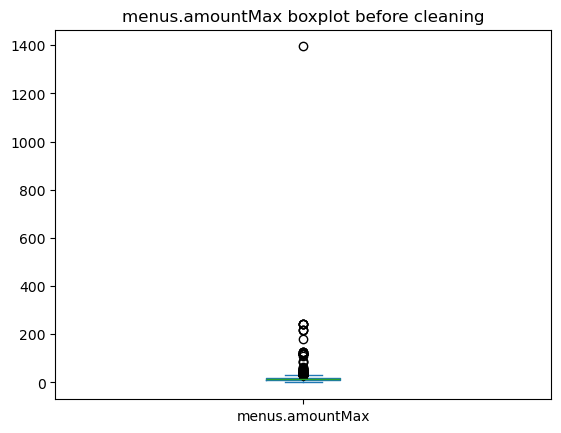

In [23]:
df['menus.amountMax'].plot.box(title='menus.amountMax boxplot before cleaning') 
print(f"Max menus.amountMax is: {df['menus.amountMax'].max()}")

In [24]:
cutRate = 1.25

before = len(df)
mask = df['menus.amountMax'] > cutRate * (df['priceRangeMax'])
removed = mask.sum()
df.drop(df[mask].index, inplace=True)
print(f"Removed {removed} outliers from menus.amountMax (>{cutRate} * priceRangeMax) out of {before} rows.")

Removed 112 outliers from menus.amountMax (>1.25 * priceRangeMax) out of 9368 rows.


Max menus.amountMax is now: 41.5


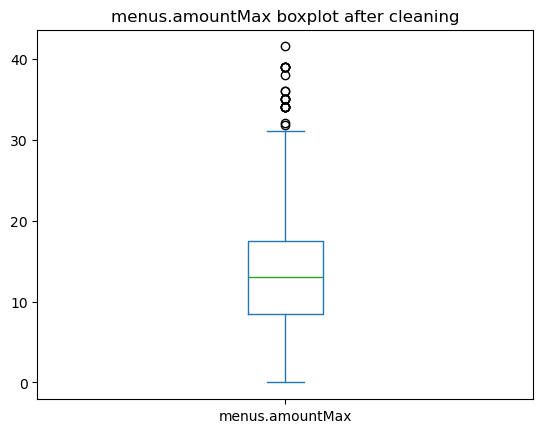

In [25]:
df['menus.amountMax'].plot.box(title='menus.amountMax boxplot after cleaning') 
print(f"Max menus.amountMax is now: {df['menus.amountMax'].max()}")

Even if the boxplot visualizes some "outliers", the max price is less than priceRangeMax.

### menus.amountMin
The problem with menus.amountMin is that almost 94% of the data are the same as menus.amountMax.

In [26]:
print("Values of menus.amountMin == menus.amountMax: ", (df['menus.amountMin'] == df['menus.amountMax']).sum())
print("Percentage of menus.amountMin == menus.amountMax: ",  f"{(df['menus.amountMin'] == df['menus.amountMax']).mean():.2%}")

Values of menus.amountMin == menus.amountMax:  8664
Percentage of menus.amountMin == menus.amountMax:  93.60%


In order to removing outliers we will use boxplots. So we will remove everything outside IQR.

<Axes: title={'center': 'menus.amountMin boxplot before cleaning'}>

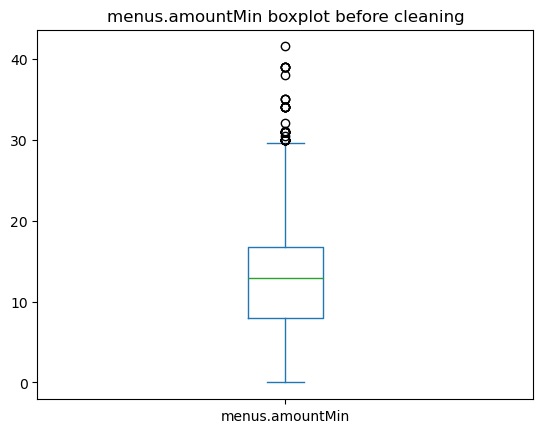

In [27]:
df['menus.amountMin'].plot.box(title='menus.amountMin boxplot before cleaning')

Removed 43 outliers from menus.amountMin outside IQR [-5.188750000000001, 29.981250000000003]


<Axes: title={'center': 'menus.amountMin boxplot after cleaning'}>

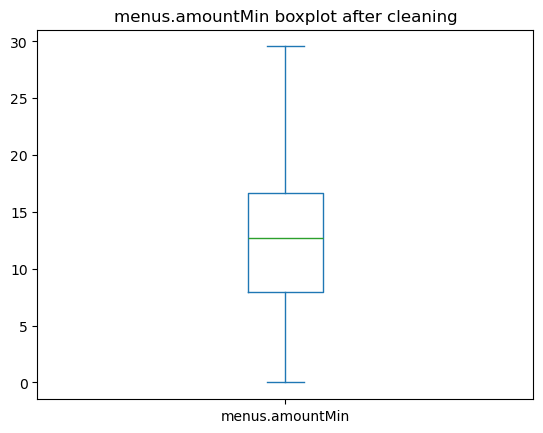

In [28]:

Q1 = df['menus.amountMin'].quantile(0.25)
Q3 = df['menus.amountMin'].quantile(0.75)
IQR = Q3 - Q1

low_bound = Q1 - 1.5 * IQR
high_bound = Q3 + 1.5 * IQR

before = len(df)
df = df[(df['menus.amountMin'] >= low_bound) & (df['menus.amountMin'] <= high_bound)]
print(f"Removed {before - len(df)} outliers from menus.amountMin outside IQR [{low_bound}, {high_bound}]")

df['menus.amountMin'].plot.box(title='menus.amountMin boxplot after cleaning')

### postalCode
In the USA, postal codes are ZIP codes, whose valid range is [00501, 99950]. Any value outside this range is considered an outlier.

In [29]:
mask_out = (df['postalCode'] < 501) | (df['postalCode'] > 99950) | df['postalCode'].isna()

print("Outlier postalCode rows:", mask_out.sum())

df = df[~mask_out]

Outlier postalCode rows: 25


### Resulting after cleaning

In [30]:
obsAfterCleaning = df.shape[0]
print(f"\nObservations before cleaning: {obsBeforeCleaning}")
print(f"Observations after cleaning: {obsAfterCleaning}")
print(f"Removed {obsBeforeCleaning - obsAfterCleaning} observations.")

# updating dfUniqueID after cleaning
dfUniqueID = df.drop_duplicates(subset=['id']).reset_index(drop=True)


Observations before cleaning: 9368
Observations after cleaning: 9188
Removed 180 observations.


# Part 3: Data Exploration

## Univariate Analisys

### Numeric

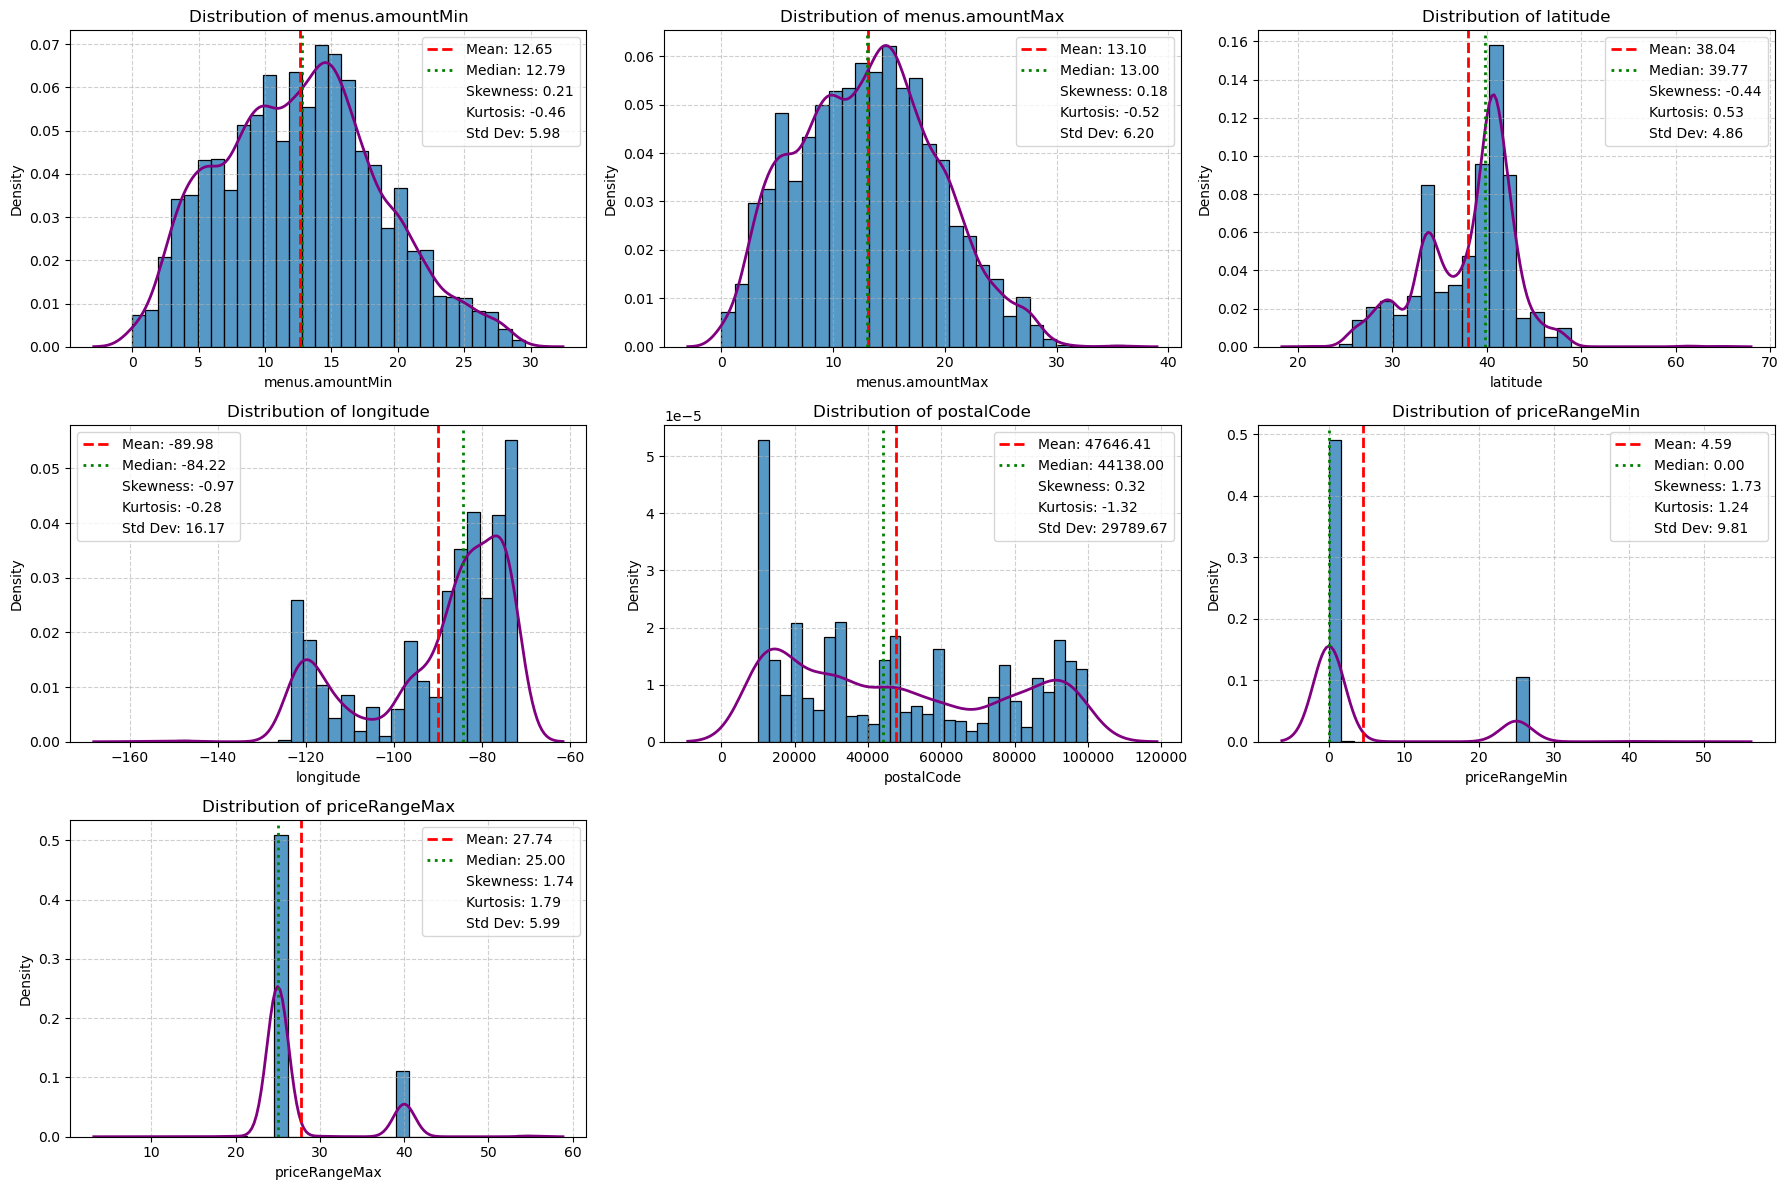

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

numericList = ['menus.amountMin', 'menus.amountMax']
numericListUniqueID = [
    'latitude', 
    'longitude', 
    'postalCode', 
    'priceRangeMin', 
    'priceRangeMax'
    ]

cols_to_plot = [(df, c) for c in numericList] + [(dfUniqueID, c) for c in numericListUniqueID] # list of (DataFrame, column) pairs

plt.figure(figsize=(18, 12))

for i, (dframe, col) in enumerate(cols_to_plot):
    s = dframe[col].dropna()

    plt.subplot(3, 3, i+1)
    ax = sns.histplot(s, bins=30, edgecolor='black', stat='density') # type: ignore
    sns.kdeplot(s, color='purple', lw=2, ax=ax) # type: ignore

    plt.title(f"Distribution of {col}")

    mean_val = s.mean()
    median_val = s.median()
    skew_val = s.skew()
    kurt_val = s.kurt()
    std_val = s.std()

    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle=':', linewidth=2,
                label=f'Median: {median_val:.2f}')

    plt.plot([], [], ' ', label=f'Skewness: {skew_val:.2f}')
    plt.plot([], [], ' ', label=f'Kurtosis: {kurt_val:.2f}')
    plt.plot([], [], ' ', label=f'Std Dev: {std_val:.2f}')

    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

From this plots we can conclude that:

1. **priceRangeMax** and **priceRangeMin** tend to cluster around values close to **25** and **40**, respectively.

2. **Latitude** shows a **bimodal distribution**: values are strongly concentrated between **approximately 30° and 45°**, which indicates a higher concentration of restaurants in the **north-central region of the United States**.

3. **Longitude** is also **bimodal**, and the separation between the two peaks is even clearer:
   - one peak around **–120**, corresponding to the **West Coast**,
   - and a much stronger peak around **–80**, corresponding to the **East Coast**.

4. **menus.amountMax** and **menus.amountMin** fall within reasonable ranges, although **menus.amountMax** shows a few values above **$30**, which can be considered higher-end items.

5. Regarding **postalCode**, the situation is more complex. We observe clear spikes at specific values. This reflects the fact that **latitude and longitude are themselves clustered along a few geographic “bands”**, meaning that many restaurants come from a limited set of ZIP code regions.

### Categorial

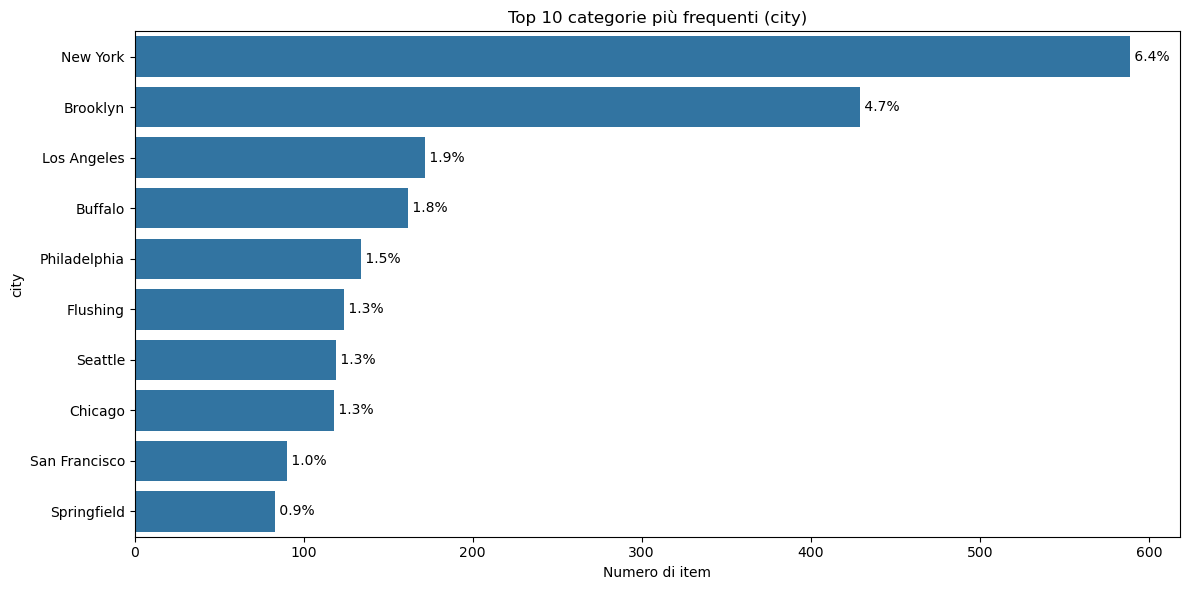

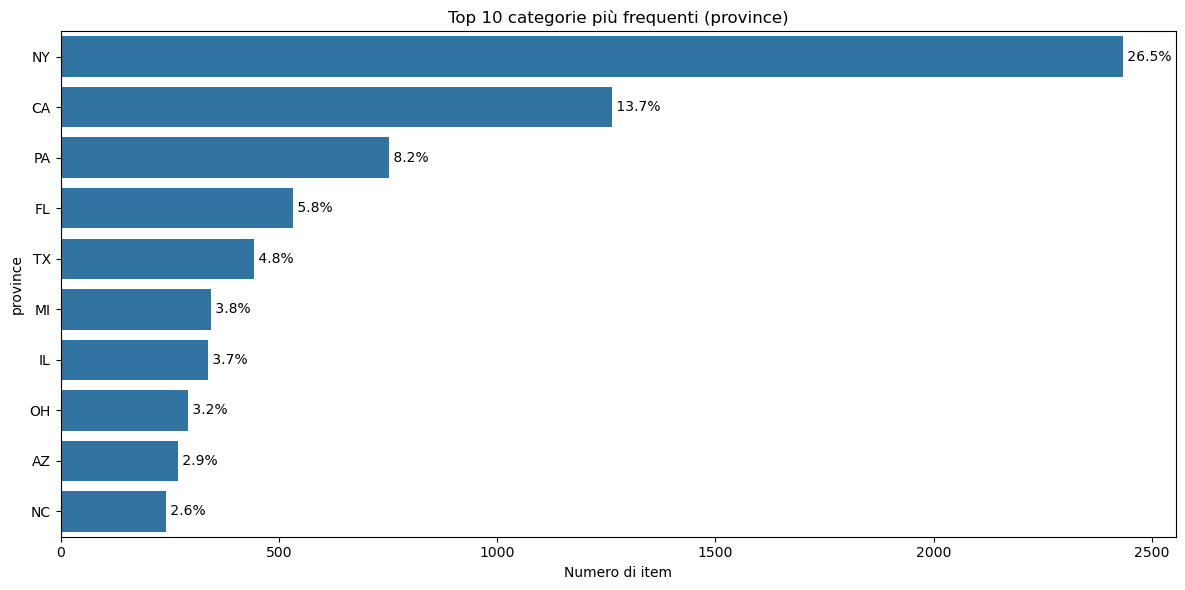

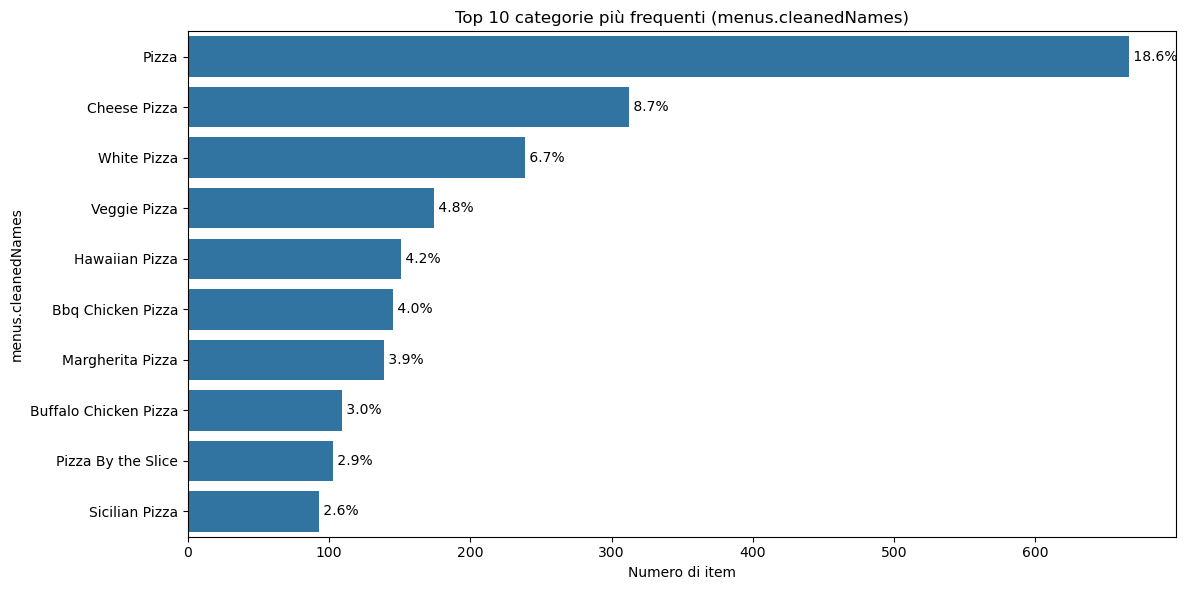

In [32]:
categorical = [
    'city',
    'province',
    'menus.cleanedNames'
]

top_n = 10

for col in categorical:
    if col not in df.columns:
        print(f"Column '{col}' not in DataFrame, skipping.")
        continue

    series = df[col].dropna()

    # Exclude "OTHER" only for menus.cleanedNames
    if col == "menus.cleanedNames":
        series = series[series != "OTHER"]

    counts = series.value_counts().head(top_n)
    total = series.shape[0]
    percentages = (counts / total * 100).round(1)

    plot_df = counts.reset_index()
    plot_df.columns = [col, "count"]
    plot_df["percentage"] = percentages.values

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=plot_df,
        x="count",
        y=col,
        orient="h"
    )

    # aggiungo etichette con percentuale
    for i, row in plot_df.iterrows():
        ax.text(
            row["count"],
            i,
            f" {row['percentage']}%",
            va="center"
        )

    ax.set_xlabel("Numero di item")
    ax.set_ylabel(col)
    ax.set_title(f"Top {top_n} categorie più frequenti ({col})")
    plt.tight_layout()
    plt.show()

From the bar charts:
1. **City distribution**
The distribution of the **city** field is highly concentrated in a few metropolitan areas:

- **New York** dominates overwhelmingly, with more than **600 restaurants**, far ahead of all other cities.
- **Brooklyn** follows as the second most represented area, which is consistent given its population density and number of restaurants.
- Other large cities such as **Los Angeles**, **Buffalo**, **Philadelphia**, **Chicago**, and **Seattle** appear with lower but still notable frequencies.
- The distribution exhibits a **strong long-tail**, where most cities appear only a small number of times.

This indicates that the dataset is **geographically biased** toward large urban centers, particularly the **New York metropolitan area**.

2. **Province distribution**
The **province** (U.S. state code) plot shows an even stronger concentration pattern:

- **NY (New York State)** is by far the most represented, with over **2500 entries**.
- Other highly represented states include **CA**, **PA**, **FL**, **TX**, and **IL**.
- Most other states appear infrequently, forming a long-tail distribution.

This confirms that the dataset is **not uniformly sampled across states**, but instead focuses heavily on a select group of regions.

3. **Cleaned menu names**
The plot of **menus.cleanedNames** shows the frequencies of menu items after cleaning and clustering:

- **Cheese Pizza** is the most common item (if we don't count Pizza, which of course is popular in a pizza restaraunt dataset).
- The distribution demonstrates that the cleaning process successfully merges many noisy, diverse menu names into a smaller number of **high-frequency semantic categories**.

This reveals the **core structure of menu offerings** across restaurants and confirms that the clustering approach produces meaningful aggregated categories.

## Multivariate Analysis

### Numeric vs Numeric

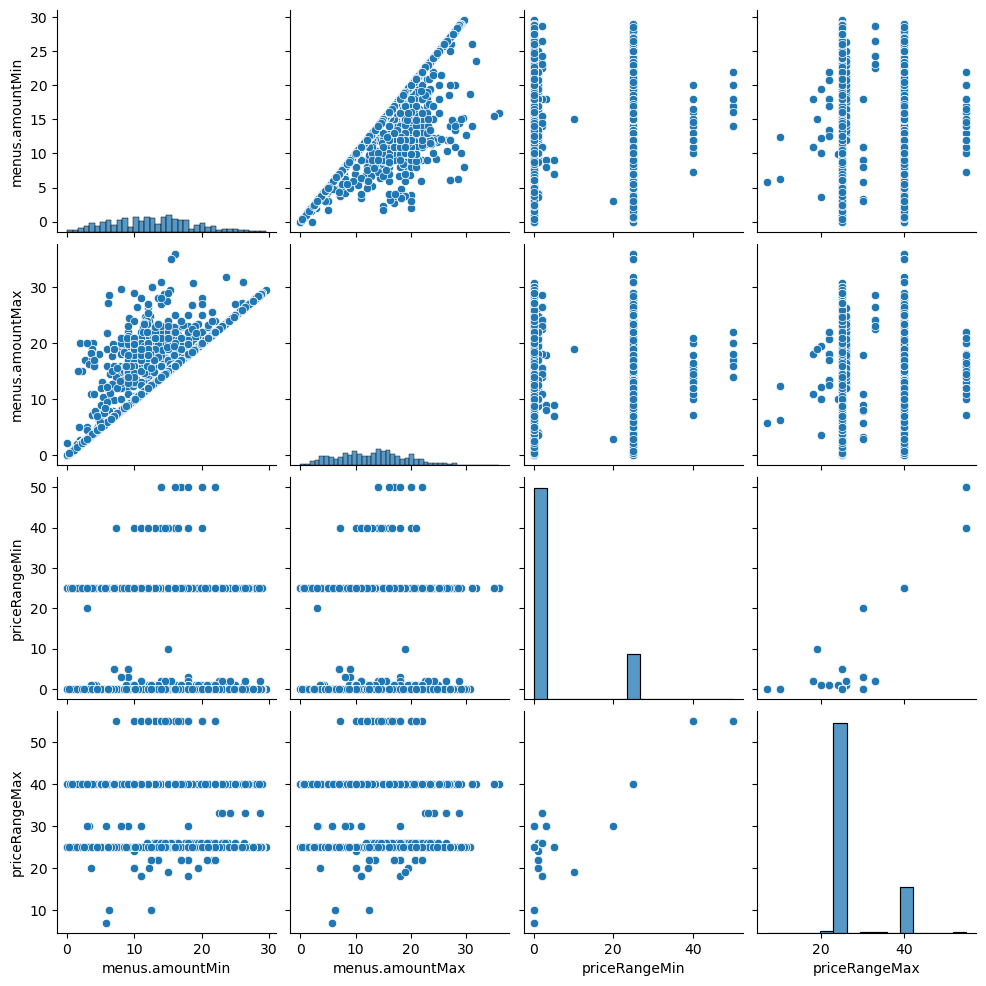

In [33]:
priceCorrelations = [
    'menus.amountMin',
    'menus.amountMax',
    'priceRangeMin',
    'priceRangeMax'
]

geographicCorrelations = [
    'longitude',
    'latitude'
]

sns.pairplot(df[priceCorrelations])
plt.show()

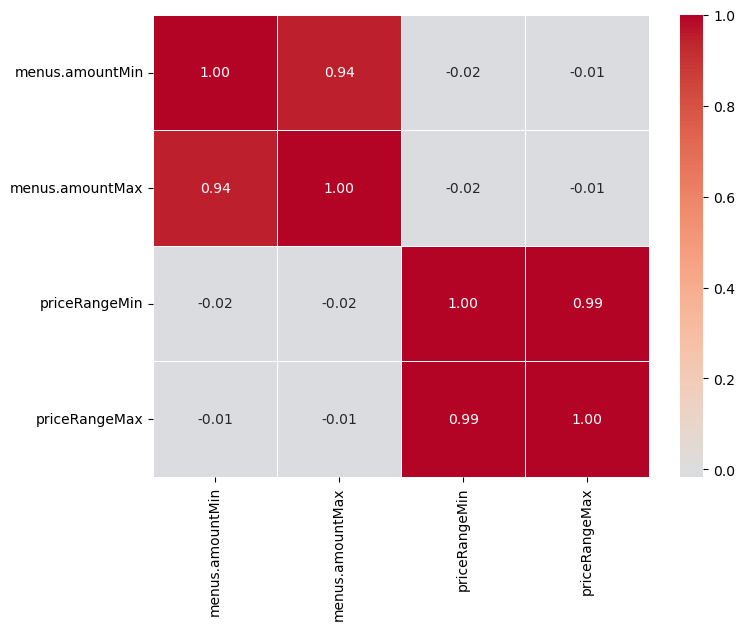

In [34]:
corrMatrix = df[priceCorrelations].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    corrMatrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.show()

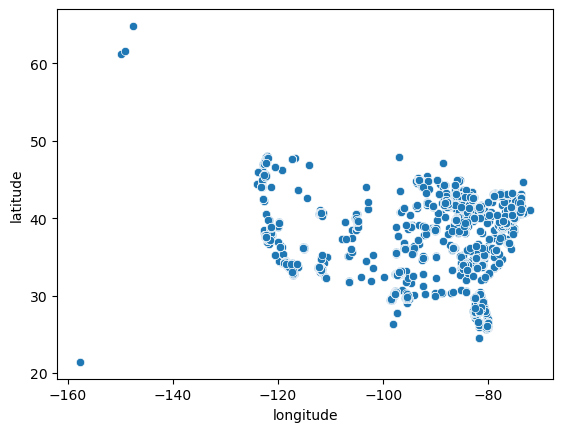

In [35]:
sns.scatterplot(df[geographicCorrelations], x='longitude', y='latitude')
plt.show()

In [36]:
import plotly.express as px
from src.utilities import PALETTE, PIZZA_SCALE, clean_strings

# ------------------------------------------------------------
# Data: count menu items per US state (province)
# ------------------------------------------------------------
# (optional but consistent with your pipeline)
df["province"] = clean_strings(df["province"].astype("string"))

counts = (
    df.dropna(subset=["province"])
      .groupby("province")
      .size()
      .reset_index(name="n_items")
)

# ------------------------------------------------------------
# Choropleth (USA)
# ------------------------------------------------------------
fig = px.choropleth(
    counts,
    locations="province",
    locationmode="USA-states",
    color="n_items",
    scope="usa",
    color_continuous_scale=PIZZA_SCALE,
)

fig.update_layout(
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    font=dict(color=PALETTE["dark_gray"], family="Montserrat, Arial"),
    margin=dict(l=0, r=0, t=0, b=0),
    coloraxis_colorbar=dict(
        title=dict(text="N. item di menu", font=dict(color=PALETTE["dark_gray"])),
        tickfont=dict(color=PALETTE["dark_gray"]),
        outlinewidth=0,
        bgcolor="rgba(0,0,0,0)",
    ),
)

fig.update_geos(
    bgcolor="rgba(0,0,0,0)",
    showland=True,
    landcolor="rgba(0,0,0,0)",
    lakecolor="rgba(0,0,0,0)",
    showlakes=False,
    showocean=False,
    showcountries=False,
    showframe=False,
    showcoastlines=False,
    subunitcolor=PALETTE["dark_gray"],
    subunitwidth=0.4,
)

fig.show()

From the scatter matrix and the correlation heatmaps, only a few relationships clearly emerge.

First, a strong correlation is observed between the price variables (`menus.amountMin` and `menus.amountMax`). This result is expected, since both variables refer to the same menu item and, in most cases, they take identical or very similar values. As such, this correlation does not provide additional analytical insight but rather confirms internal consistency in the pricing fields.

A second visible correlation involves **latitude and longitude**. When plotted against each other, these variables naturally reproduce the geographic shape of the United States. Again, this pattern is expected and reflects spatial structure rather than an intrinsic relationship between the variables themselves.

Beyond these cases, the numeric correlation analysis does not reveal strong linear relationships among the remaining features. This suggests that:
- most numeric variables capture different aspects of the data,
- potential relationships may be **non-linear**, **context-dependent**, or mediated by categorical or geographic factors.

The geographic choropleth map further reinforces this interpretation. While it highlights clear **spatial heterogeneity** in the distribution of menu items across U.S. states (with higher concentrations in more populous or urbanized areas), it does not directly imply causal relationships with pricing or menu complexity. Instead, it suggests that geography may act as a **structuring variable**, motivating downstream analyses that explicitly account for regional effects (e.g. coastal vs inland, state-level aggregation, or spatial segmentation).

Overall, this exploratory correlation analysis indicates that simple pairwise correlations are insufficient to capture the structure of the data, and that richer representations—such as engineered features, categorical groupings, or geographic stratification—are required to uncover more meaningful patterns.

### Numerical vs Categorial
For a multivariate analisys of numerical vs categorial features we will check top N against a numerical value.

#### City

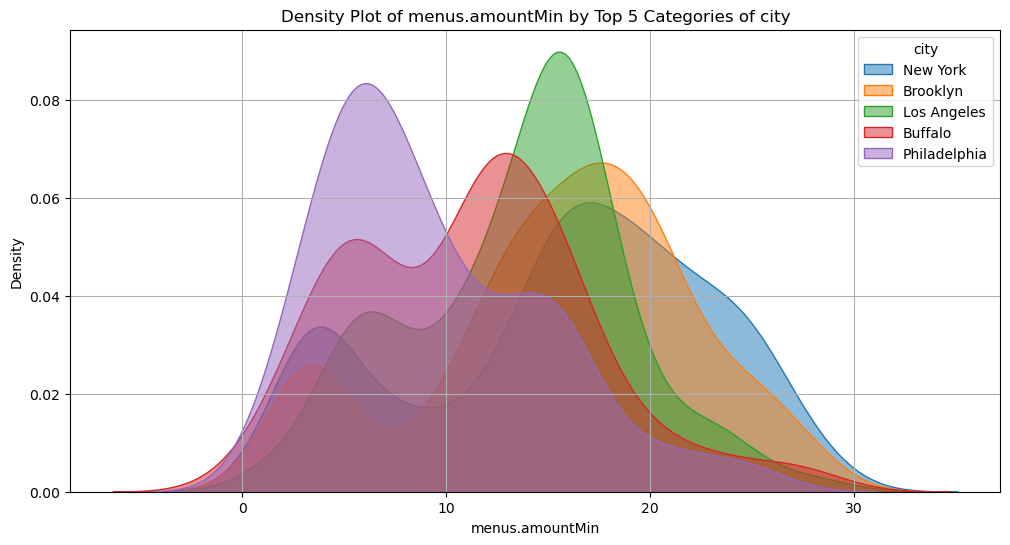

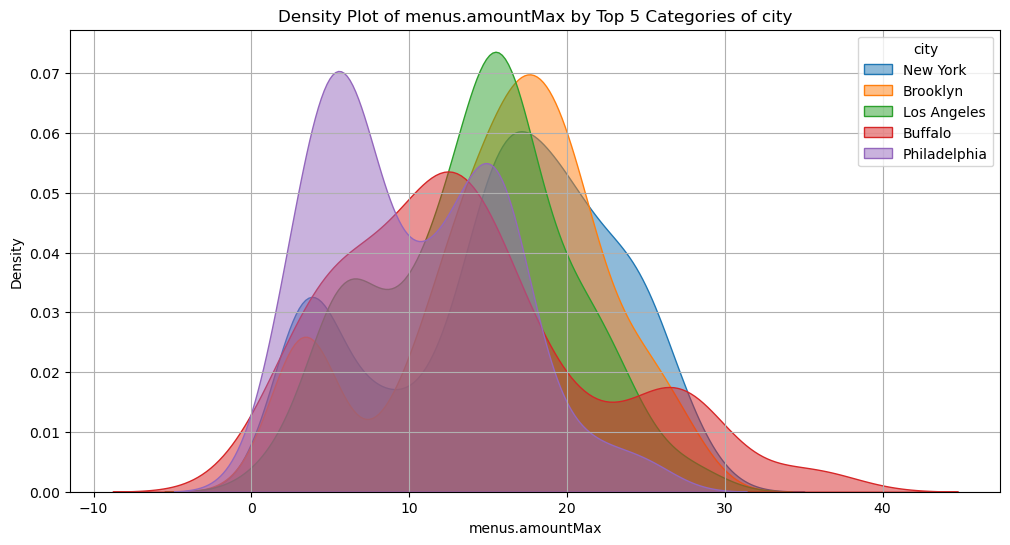

In [37]:
# city report
top_n = 5

from src.utilities import plotCategorialVsNumeric

for price_col in ['menus.amountMin', 'menus.amountMax']:
    plotCategorialVsNumeric(
        df=df,
        categorialCol='city',
        numericCol=price_col,
        top_n=top_n
    )

From the graphs we could say:
1. There is clear **geographic variation** in both minimum and maximum menu amounts. Log Angeles, New York and Brooklyn tend to have higher menu prices where New York showing the widest spred.
2. Philadelphia and Buffalo generally **lower** typycal prices.

But from that we could ask: "Are the cities near to coast more expennsive than internal ones?"

### Coastal vs Internal cities - geographic labeling

In [38]:
import pandas as pd

from src.utilities import haversine_distance_km, is_coastal

# ------------------------------------------------------------
# Reference coastal points (rough US coastline approximation)
# ------------------------------------------------------------
US_COAST_POINTS = [
    # Atlantic coast
    (44.5, -67.5),   # Maine
    (42.3, -70.9),   # Boston
    (40.6, -73.8),   # New York
    (39.3, -74.5),   # Atlantic City
    (36.8, -75.9),   # Virginia Beach
    (34.2, -77.9),   # Wilmington
    (32.1, -81.1),   # Savannah
    (25.8, -80.1),   # Miami

    # Gulf of Mexico
    (30.3, -87.7),   # Pensacola
    (29.0, -90.0),   # Louisiana coast
    (29.3, -94.8),   # Galveston
    (27.8, -97.4),   # Corpus Christi

    # Pacific coast
    (32.7, -117.2),  # San Diego
    (34.0, -118.5),  # Los Angeles
    (36.6, -121.9),  # Monterey
    (37.8, -122.5),  # San Francisco
    (44.0, -124.1),  # Oregon coast
    (47.6, -122.4),  # Seattle

    # Alaska
    (58.3, -134.4),  # Juneau
    (61.2, -149.9),  # Anchorage

    # Hawaii
    (21.3, -157.8),  # Honolulu
    (19.7, -155.1),  # Hilo
]

# ------------------------------------------------------------
# Apply coastal classifier to dataset
# ------------------------------------------------------------
MAX_DIST_KM = 50.0

# NOTE: utilities.is_coastal expects:
# is_coastal(lat, lon, coastline_points, max_distance_km=...)
df["coastal_city"] = df.apply(
    lambda r: is_coastal(
        r["latitude"],
        r["longitude"],
        coastline_points=US_COAST_POINTS,
        max_distance_km=MAX_DIST_KM,
    ),
    axis=1,
).astype(bool)

df["internal_city"] = (~df["coastal_city"]).astype(bool)

# Quick sanity check
df["coastal_city"].value_counts(normalize=True)

coastal_city
False    0.67229
True     0.32771
Name: proportion, dtype: float64

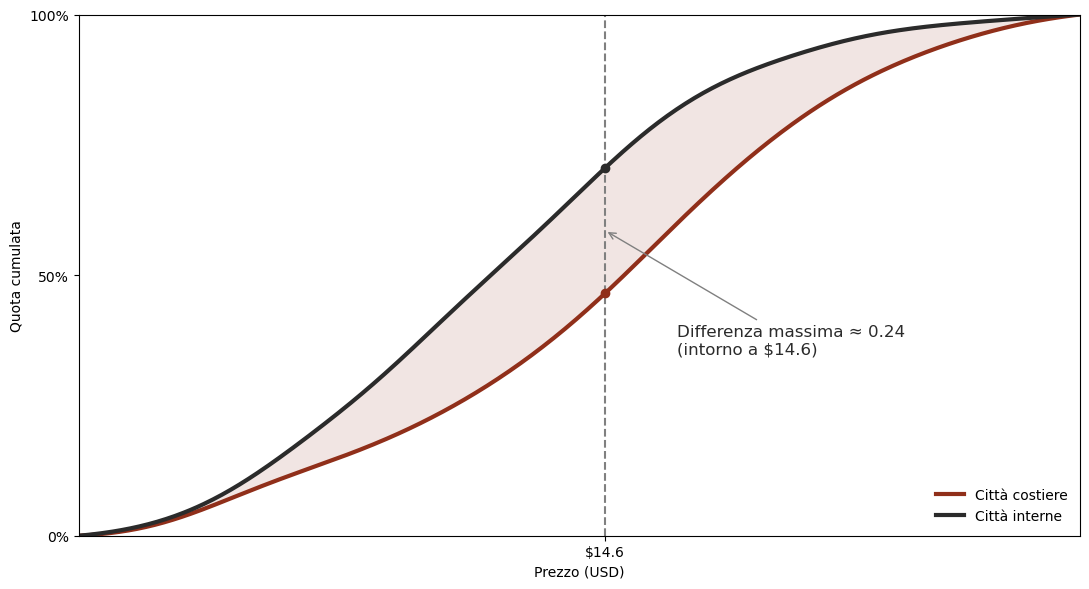

In [39]:
from src.utilities import plot_smooth_cdf

plot_smooth_cdf(
    df,
    "menus.amountMin",
    bw_adjust=1.25,
    transparent_bg=True
)

From the ECDF plots, we can observe that coastal cities tend to have higher menu prices compared to internal cities.

#### Province

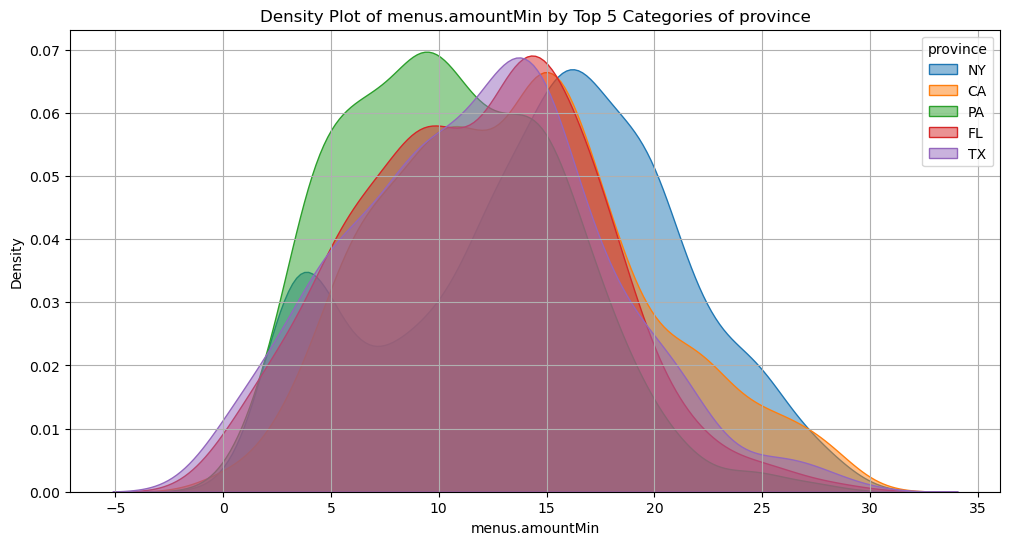

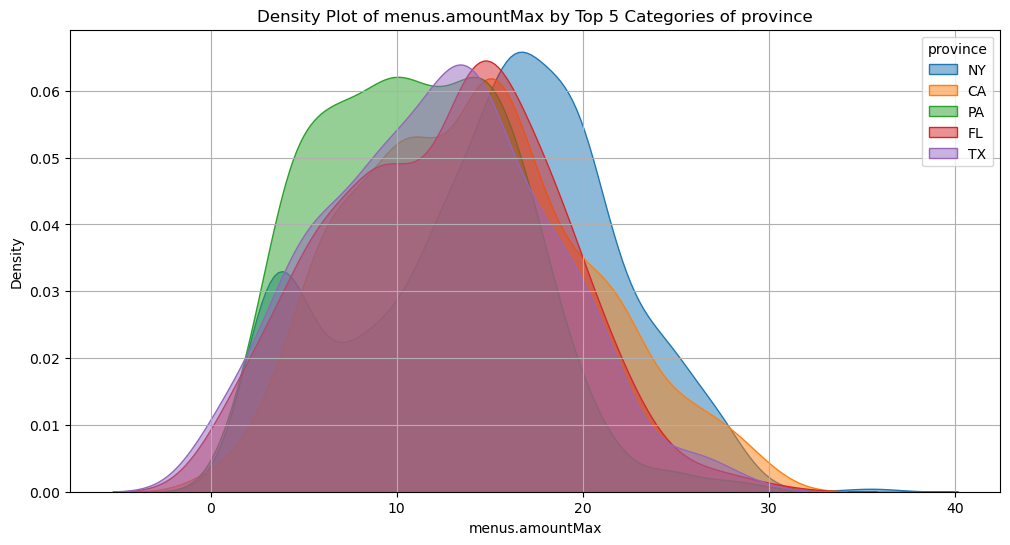

In [41]:
from src.utilities import plotCategorialVsNumeric

for price_col in ['menus.amountMin', 'menus.amountMax']:
    plotCategorialVsNumeric(
        df=df,
        categorialCol='province',
        numericCol=price_col,
        top_n=5
    )

From observations of top 5 province we can say:
1. NY has the highest prices.
2. FL and CA has similar distributions. 
3. PA has the lowest prices.
4. TX is the most wide distribution (here).

#### menus.cleanedNames

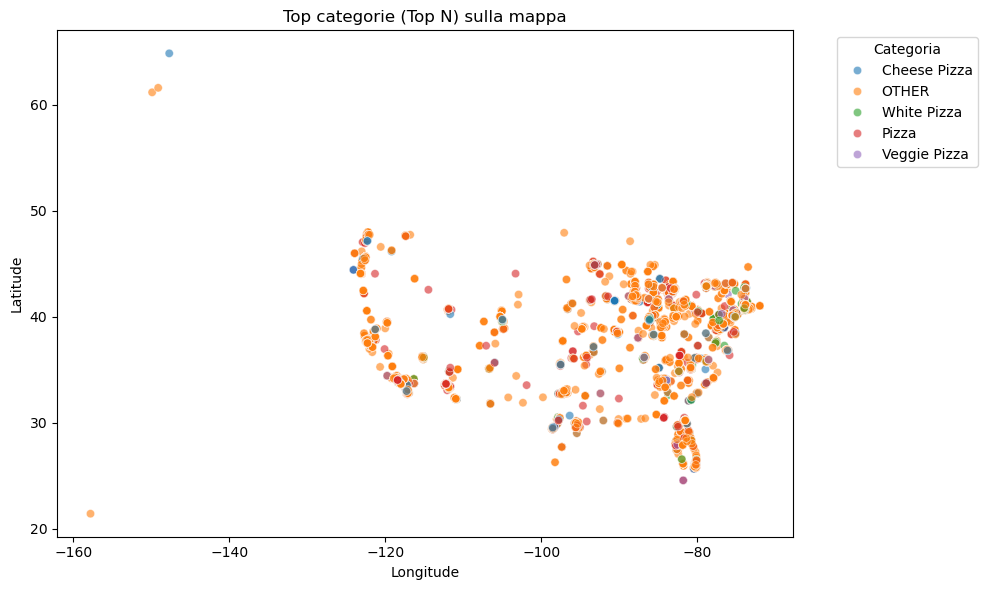

In [ ]:
from src.utilities import returnTopN

topN_series = returnTopN(df["menus.cleanedNames"], n=5)
top_categories = topN_series.index  
df_top = df[df["topN_series = returnTopN(df["menus.cleanedNames"], n=5)
top_categories = topN_series.index  
df_top = df[df["menus.cleanedNames"].isin(top_categories)]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_top,
    x="longitude",
    y="latitude",
    hue="menus.cleanedNames",
    alpha=0.6
)

plt.title("Top categorie (Top N) sulla mappa")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Categoria", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()menus.cleanedNames"].isin(top_categories)]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_top,
    x="longitude",
    y="latitude",
    hue="menus.cleanedNames",
    alpha=0.6
)

plt.title("Top categorie (Top N) sulla mappa")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Categoria", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

The map shows that the top five pizza categories are spread broadly across the United States, with no clear geographic clustering that separates one type from another. While some regions-particularly the East Coast and parts of the Midwest-display higher concentrations of restaurants, all five categories appear to be evenly mixed throughout these areas.

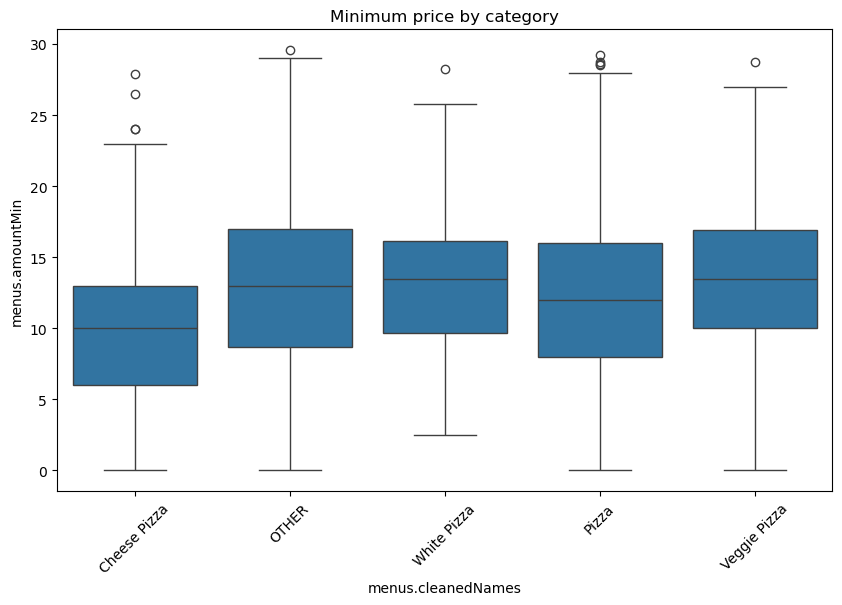

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_top, 
    x="menus.cleanedNames", 
    y="menus.amountMin"
)
plt.xticks(rotation=45)
plt.title("Minimum price by category")
plt.show()

The chart shows that minimum prices are broadly similar across the top pizza categories, with overlapping distributions and comparable medians. Some categories exhibit wider variability and a few low-price outliers, but no category stands out as consistently cheaper or more expensive than the others. The plot also helps explain why cheese pizza is the most common choice: it tends to be priced lower than the other categories, making it a more accessible and widely offered option.